# Reboot - SQL Advanced

Tonight, we will use the Blog SQLite database:

In [ ]:
!tree

## 1. Schema ERD

❓ Open the `data/blog.sqlite` in DBeaver, explore the schema and draw it on [kitt.lewagon.com/db](https://kitt.lewagon.com/db).

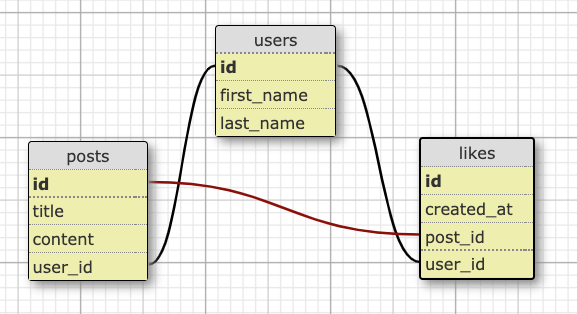

---
## 2. Most liked posts

Complete the code to get **the 3 most liked posts**:

In [4]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("data/blog.sqlite")
c = conn.cursor()

# TODO: write the query
# Return 3 most liked posts (title, author name, number of likes)

query = """
select title, (users.first_name || '  ' || users.last_name) as author, count(*) likes 
from posts
join likes on posts.id = likes.post_id
join users on posts.user_id = users.id
group by posts.id
order by count(*) desc
limit 3
"""
# c.execute(query)
# result = c.fetchall()
# print(result)
# TODO: Execute the query

# TODO: Fetch and print the results
pd.read_sql_query(query, conn)

,title,author,likes
0,Half imagine another.,Melissa Henry,84
1,Side foot leader popular.,Cynthia Raymond,82
2,Area paper whatever mean.,Alexander Cook,81


---

### Pretty Print using _pandas_

The readbility of our `print()` statements is not so good.

Next week, we will introduce [pandas](https://pandas.pydata.org/) which will vastly improve the UX of our data exploration in Notebooks.

Execute the following cell to load `pandas` library:

In [ ]:
#import pandas as pd

Then try the previous `query` again, delegating the job of fetching results + displaying them to the `read_sql_query` function of `pandas`:

In [ ]:
pd.read_sql_query(query, conn)

---
## 3. Find the three users who 'liked' the most

In [5]:
query = """
SELECT first_name || ' ' || last_name as user_name ,count(*) as likes
from users
join likes on likes.user_id = users.id
group by user_id
ORDER by likes DESC
limit 3
"""
pd.read_sql_query(query, conn)

,user_name,likes
0,Michael Allen,236
1,Donna Ramirez,233
2,Hayley Williams,227


---
## 4. Find the most liked author

In [8]:
query = """
SELECT (first_name || ' ' || last_name) author, count(*) likes 
from posts
JOIN likes on likes.post_id = posts.id
JOIN users ON users.id = posts.user_id
GROUP BY author
order by likes DESC
LIMit 1
"""
pd.read_sql_query(query, conn)

,author,likes
0,Teresa Moore,647


---
## ~~5. Who are the authors of the 3 most liked posts?~~

In [ ]:
query = """

"""
pd.read_sql_query(query, conn)

---
## ~~6. How many people liked at least one post?~~

In [9]:
query = """
    SELECT COUNT(DISTINCT likes.user_id)
    FROM likes
    
"""
pd.read_sql_query(query, conn)

,COUNT(DISTINCT likes.user_id)
0,49


---
## 6A. Which post does not have any like? :(

In [10]:
# Return the first 10 blog posts (title) that do not have any likes

query = """
SELECT title
from posts
left join likes on likes.post_id = posts.id
where likes.id is null 
limit 10
"""
pd.read_sql_query(query, conn)

,title
0,Run total policy.
1,Arrive film growth close.
2,Increase radio work.
3,Fight keep any knowledge.
4,Quite discuss environmental would speak to.
5,Image shoulder class expert quite perform.
6,Before car out right.
7,Place list election author model.
8,Performance body bag cost network far theory.
9,Increase indeed computer single tonight histor...


---
## 6B. Which author does not have any like? :(

In [11]:
# Return a list of authors that do not have any likes
query = """
SELECT distinct (u.first_name || ' ' || u.last_name) author
FROM posts p
LEFT JOIN users u ON u.id = p.user_id
LEFT JOIN likes l ON l.post_id = p.id
WHEre l.id is NULL
order by author
limit 10
"""
# SELECT distinct (u.first_name || ' ' || u.last_name) author
# FROM posts p
# LEFT JOIN users u ON u.id = p.user_id
# LEFT JOIN likes l ON l.post_id = p.id
# --WHEre l.id is NULL
# GROUP BY author
# HAVING COUNT(l.id) = 0
# order by author
# limit 10
pd.read_sql_query(query, conn)

,author
0,Angela Smith
1,Chad Bentley
2,Connie Hall
3,Courtney Owens
4,Cynthia Cortez
5,David Tanner
6,Donald Williamson
7,Henry Swanson
8,James Alexander
9,John Beltran


## 7. Let's play with strings

In [12]:
# Count how many posts grouped by title_length_bucket
# title length should be grouped in 10, 20, 30 ... buckets
# the title length should be calculated without the white spaces
query = """
    with new as (
select LENGTH(replace(replace(trim(posts.title)," ",""),".","")) as cleaned_name
FROM posts)
SELECT CAST(new.cleaned_name/10 as int)*10 + 10 as bin, count(*) as bin_count
FROM new
group by bin 
"""
pd.read_sql_query(query, conn)

,bin,bin_count
0,20,43
1,30,108
2,40,102
3,50,57
4,60,5


---
## 8. Compute the cumulative number of likes per day

In [ ]:
query = """
    select DISTINCT likes.created_at, COUNT(likes.id) over (order by created_at)
    from likes 
"""
#pd.read_sql_query(query, conn)

In [ ]:
# Other questions
# Cumulative number of likes over time (monthly) PER author

# select DISTINCT(first_name || ' ' || last_name) author, strftime('%Y-%m', date(likes.created_at)) as month, 
# COUNT(likes.id) over (
#   PARTITION BY (first_name || ' ' || last_name)
#   order by strftime('%Y-%m', date(likes.created_at))) as monthly_count
# from users
# left join posts on users.id = posts.user_id
# left join likes on posts.id = likes.post_id

---
## 9. (Optional) Who's the biggest fan of each author?

The biggest fan of an author is defined as the user who liked the most the author's posts.
<br><br>
<details>
    <summary>💡 Click for Hint</summary>
    You might need to use <code>WITH</code>
</details>


In [13]:
query = """
    WITH likers AS (
        SELECT 
            --p.title, 
            (u.first_name || ' ' || u.last_name) author,
            (likers.first_name || ' ' || likers.last_name) liker
        FROM users u 
        join posts p on p.user_id = u.id 
        join likes l on l.post_id = p.id
        join users likers ON likers.id = l.user_id
        ORDER by 2, 1
      )
    , already_ranked AS 
    (
      SELECT author, liker, COUNT(*) likes
       ,DENSE_RANK() OVER (PARTITION BY author order by COUNT(*) DESC) rank
      FROM likers
      GROUP BY author, liker
      ORDER BY author, COUNT(*) DESC
     )

     SELECT author, liker, rank
     FROM already_ranked
     WHERE rank = 1
"""
pd.read_sql_query(query, conn)

,author,liker,rank
0,Alexander Cook,Jeremiah Ruiz,1
1,Brenda Griffin,Michael Allen,1
2,Brett Johnston,Tristan Kelley,1
3,Brett Johnston,Kayla Higgins,1
4,Brett Johnston,Gary Garza,1
5,Brittany Miller,Gary Garza,1
6,Brittany Miller,Barbara Hurst,1
7,Cynthia Raymond,Donald Gray,1
8,David Boyd,Barbara Hurst,1
9,Donna Smith,Karen Brown,1
